# Using NLP to compute nean length utterance and number of filled pauses in a speaking task

In this notebook, we provide code for two analyses in a speaking experiment. In this experiment, participants were asked to respond to simple prompts while doing a simulated driving task (i.e., driving a car) and also without driving. We compared the mean length utterance (number of morphemes per utterance, utterance=words between pauses, Kemper et al., 2003) between the conditions (easy driving, hard driving, and speaking only) to test whether participants uttered less complex sentences in the cognitively more challenging conditions. We additionally tested whether the number of filled pauses differed among the conditions. We predicted that participants would produce more filled pauses in the more challenging driving conditions.

## Mean length utterance

In [1]:
import spacy
import de_dep_news_trf
from spacy.matcher import Matcher
from spacy_syllables import SpacySyllables
import glob
from praatio import textgrid
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from patsy.contrasts import Helmert
from patsy.contrasts import Treatment

In [2]:
# Modell laden
nlp = spacy.load("de_core_news_sm")
#nlp = spacy.load("de_dep_news_trf")
#nlp = de_dep_news_trf.load()
syllables = SpacySyllables(nlp, "de")
nlp.add_pipe("syllables", after="tagger")

In [3]:
# leere Liste erstellen und TextGrid-Dateien in der Liste speichern
tg_files = []

In [4]:
# TextGrid-Dateien zur Liste tg_dateien hinzufügen
for file in glob.glob("*.TextGrid"):
    tg_files.append(file)

In [5]:
len(tg_files) # make sure we have the correct number of files

23

In [6]:
def compute_mlu(file):
    """
    This function computes the mean length utterance for each file by means of the following steps:
    1. Splits the string of the file name and saves the first two elements, which are the participant number and condition
    2. Reads the textgrid file
    3. Creates an object that consists of the participant tier of the textgrid (the text the participant uttered)
    4. Creates a list of all text from the participant's speech task
    5. Removes NA and xxx (NA is when the experimenter was talking; xxx are pauses in the speech stream)
    6. Parses the text using the nlp model "de_cores_news_sm"
    7. Counts the number of morphemes in the continuous speech
    8. Counts the number of utterances (speech between pauses)
    9. Computes the mean length utterance = morphemes/utterances
    10. Returns strings of the participant number and condition and the mean length utterance in a list
    """
    info = file.split('_',2)
    tg = textgrid.openTextgrid(file, includeEmptyIntervals=False)
    participant_tier = tg.getTier('Participant')
    labelList = [entry.label for entry in participant_tier.entries]
    text = ' '.join(labelList)
    remove = ['xxx', 'na']
    text_new = [word for word in text.split() if word.lower() not in remove]
    new_text = " ".join(text_new)
    doc = nlp(new_text)
    morphs = len([token.morph for token in doc]) # check to make sure this is counting morphemes correctly!
    matcher = Matcher(nlp.vocab)
    pattern = [{"LOWER": "na", "OP": "*"}, {"LOWER": "xxx", "OP": "*"}]
    matcher.add("UTTERANCE_BOUNDARIES", [pattern])
    doc2 = nlp(text)
    matches = matcher(doc2)
    utterances = len(matches)-1
    MLU = round(morphs/utterances,2)
    return [info[0], info[1], MLU]

In [7]:
MLU_all = map(compute_mlu, tg_files)

In [8]:
data = list(MLU_all)
df = pd.DataFrame(data, columns = ['Participant', 'Condition', 'MLU']) 

In [9]:
df.head()

,Participant,Condition,MLU
0,102,speakingonly,6.98
1,112,speakingonly,5.21
2,113,easy,5.59
3,102,hard,7.33
4,112,hard,4.44


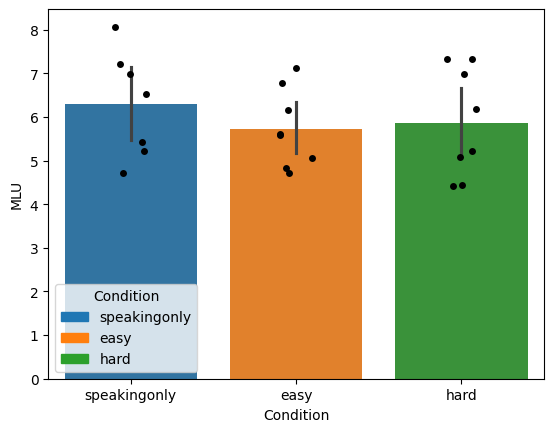

In [10]:
sns.barplot(data=df, x="Condition", y="MLU", estimator="mean", errorbar=("ci", 95), hue="Condition")
sns.stripplot(data=df, x="Condition", y="MLU", color="black", legend=False)
plt.show()

In [11]:
levels = ['easy', 'hard', 'speakingonly']
contrast = Helmert().code_without_intercept(levels)
print(contrast.matrix)

[[-1. -1.]
 [ 1. -1.]
 [ 0.  2.]]


In [12]:
mod = ols(formula="MLU ~ C(Condition, contrast, levels=levels)", data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    MLU   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                 -0.046
Method:                 Least Squares   F-statistic:                    0.5201
Date:                Thu, 18 Jan 2024   Prob (F-statistic):              0.602
Time:                        16:24:05   Log-Likelihood:                -33.739
No. Observations:                  23   AIC:                             73.48
Df Residuals:                      20   BIC:                             76.89
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [13]:
# See this page for interpreting output/getting condition means with Helmert contrasts: https://www.statsmodels.org/dev/contrasts.html
grouped = df.groupby('Condition')
grouped['MLU'].mean()
#cond_means = df.groupby("Condition")["MLU"].mean()
#cond_means[1] - cond_means[0]
#k = 3
#1./k * (cond_means[2] - ((cond_means[1]+cond_means[0])/2))
#1./k * (cond_means[1] - cond_means[0])

Condition
easy            5.732500
hard            5.873750
speakingonly    6.307143
Name: MLU, dtype: float64

In [14]:
# Try with treatment contrasts to see if either driving condition differs from the speaking only condition
levels = ['easy', 'hard', 'speakingonly']
contrast_treat = Treatment(reference=2).code_without_intercept(levels)
print(contrast.matrix)

[[-1. -1.]
 [ 1. -1.]
 [ 0.  2.]]


In [15]:
mod_treat = ols(formula="MLU ~ C(Condition, contrast_treat, levels=levels)", data=df)
res_treat = mod_treat.fit()
print(res_treat.summary())

                            OLS Regression Results                            
Dep. Variable:                    MLU   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                 -0.046
Method:                 Least Squares   F-statistic:                    0.5201
Date:                Thu, 18 Jan 2024   Prob (F-statistic):              0.602
Time:                        16:24:05   Log-Likelihood:                -33.739
No. Observations:                  23   AIC:                             73.48
Df Residuals:                      20   BIC:                             76.89
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

## Filled pauses

In [16]:
def count_filled_pauses(file):
    """
    This function counts the number of filled pauses (äh/ähm) in the speech task for each participant and condition with the following steps:
    1. Splits the string of the file name and saves the first two elements, which are the participant number and condition
    2. Reads the textgrid file
    3. Creates an object that consists of the participant tier of the textgrid (the text the participant uttered)
    4. Creates a list of all text from the participant's speech task
    5. Finds instances of 'äh' or 'ähm' and counts them
    6. Returns strings of the participant number and condition and the number of filled pauses saved in a list
    """
    info = file.split('_',2)
    tg = textgrid.openTextgrid(file, includeEmptyIntervals=False)
    participant_tier = tg.getTier('Participant')
    labelList = [entry.label for entry in participant_tier.entries]
    text = ' '.join(labelList)
    matcher = Matcher(nlp.vocab)
    pattern = [{"LOWER": "äh", "OP": "*"}, 
               {"LOWER": "ähm", "OP": "*"}, 
               {"LOWER": "hm", "OP": "*"}, 
               {"LOWER": "mm", "OP": "*"},
              {"LOWER": "uff", "OP": "*"}]
    matcher.add("FILLED_PAUSES", [pattern])
    doc = nlp(text)
    matches = matcher(doc)
    FP = len(matches)
    return [info[0], info[1], FP]

In [17]:
FP_all = map(count_filled_pauses, tg_files)

In [18]:
data_fp = list(FP_all)
df_fp = pd.DataFrame(data_fp, columns = ['Participant', 'Condition', 'Number_filled_pauses']) 

In [19]:
df_fp.sort_values(by=['Participant']).head()

,Participant,Condition,Number_filled_pauses
20,101,easy,60
14,101,speakingonly,66
0,102,speakingonly,7
3,102,hard,12
12,102,easy,18


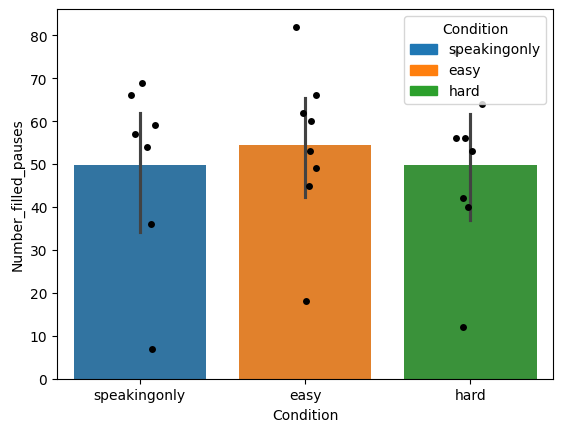

In [20]:
sns.barplot(data=df_fp, x="Condition", y="Number_filled_pauses", estimator="mean", errorbar=("ci", 95), hue="Condition")
sns.stripplot(data=df_fp, x="Condition", y="Number_filled_pauses", color="black", legend=False)
plt.show()

In [21]:
mod = ols(formula="Number_filled_pauses ~ C(Condition, contrast, levels=levels)", data=df_fp)
res = mod.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     Number_filled_pauses   R-squared:                       0.014
Model:                              OLS   Adj. R-squared:                 -0.085
Method:                   Least Squares   F-statistic:                    0.1402
Date:                  Thu, 18 Jan 2024   Prob (F-statistic):              0.870
Time:                          16:24:12   Log-Likelihood:                -99.636
No. Observations:                    23   AIC:                             205.3
Df Residuals:                        20   BIC:                             208.7
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [22]:
mod_treat = ols(formula="Number_filled_pauses ~ C(Condition, contrast_treat, levels=levels)", data=df_fp)
res_treat = mod_treat.fit()
print(res_treat.summary())

                             OLS Regression Results                             
Dep. Variable:     Number_filled_pauses   R-squared:                       0.014
Model:                              OLS   Adj. R-squared:                 -0.085
Method:                   Least Squares   F-statistic:                    0.1402
Date:                  Thu, 18 Jan 2024   Prob (F-statistic):              0.870
Time:                          16:24:12   Log-Likelihood:                -99.636
No. Observations:                    23   AIC:                             205.3
Df Residuals:                        20   BIC:                             208.7
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

# Syllables

In this section, we will try to count the number of syllables per second (speech rate) in a quick way. Unfortunately the syllable counter was not accurate enough (counted only one syllable for 'oder' and 'aber'), so we cannot use it. We will either try to train and update the model or do this manually.

In [23]:
def count_syllables(file):
    """
    This function counts the number of syllables in the speech task for each participant and condition with the following steps:
    1. Splits the string of the file name and saves the first two elements, which are the participant number and condition
    2. Reads the textgrid file
    3. Creates an object that consists of the participant tier of the textgrid (the text the participant uttered)
    4. Creates a list of all text from the participant's speech task
    5. Removes NA and xxx (NA is when the experimenter was talking; xxx are pauses in the speech stream)
    6. Parses the text using the nlp model "de_cores_news_sm"
    7. Counts the number of syllables for each word
    8. Returns the participant number, condition, and number of syllables in a list
    """
    info = file.split('_',2)
    tg = textgrid.openTextgrid(file, includeEmptyIntervals=False)
    participant_tier = tg.getTier('Participant')
    labelList = [entry.label for entry in participant_tier.entries]
    text = ' '.join(labelList)
    remove = ['xxx', 'na', 'prag', '']
    text_new = [word for word in text.split() if word.lower() not in remove]
    new_text = " ".join(text_new)
    doc = nlp(new_text)
    data = [(token.text, token._.syllables_count) for token in doc]
    data_df = pd.DataFrame(data, columns = ['word', 'nr_syllables'])
    syllables = data_df['nr_syllables'].sum()
    duration_list = []
    for start, stop, _ in participant_tier.entries:
        duration_list.append(stop - start)
    total_time = sum(duration_list)
    speaking_rate = syllables/total_time
    return [info[0], info[1], syllables, total_time, speaking_rate]

In [24]:
syllables = map(count_syllables, tg_files)

In [25]:
data_syl = list(syllables)
df_syl = pd.DataFrame(data_syl, columns = ['participant', 'condition', 'syllables', 'total_time', 'speaking_rate']) 

In [26]:
df_syl.sort_values(by=['participant']).head()

,participant,condition,syllables,total_time,speaking_rate
20,101,easy,1467.0,511.110000,2.870224
14,101,speakingonly,1570.0,439.960000,3.568506
0,102,speakingonly,1302.0,475.000000,2.741053
3,102,hard,1276.0,485.000000,2.630928
12,102,easy,1159.0,542.545102,2.136228
